In [7]:
import torch, os
from monai.networks.nets import SegResNet
from monai import transforms
from my_segmentation.ProstateSeg.dataset.prostateSeg import prostateSeg
from monai.data import DataLoader, decollate_batch
from monai.losses import DiceCELoss, DiceLoss

In [10]:
def _get_loader(modality):
    file_root = "/Users/qixinhu/Project/CUHK/Prostate/PAIsData/0426/qixin/SEG"
    train_samples = []
    with open(os.path.join(file_root,'train_case_level.txt'), 'r') as f:
        lines = f.readlines()
        for line in lines:
            sample = os.path.join(file_root, line.strip() + '.npz')
            train_samples.append(sample)

    test_samples = []
    with open(os.path.join(file_root,'test_case_level.txt'), 'r') as f:
        lines = f.readlines()
        for line in lines:
            sample = os.path.join(file_root, line.strip() + '.npz')
            test_samples.append(sample)

    x = 128
    y = 128
    z = 16


    train_img_transform = transforms.Compose(
        [
            transforms.EnsureChannelFirst(channel_dim=0),
            transforms.RandSpatialCrop(roi_size=[x, y, z], random_size=False),
            transforms.RandFlip(prob=0.5, spatial_axis=0),
            transforms.RandFlip(prob=0.5, spatial_axis=1),
            transforms.RandFlip(prob=0.5, spatial_axis=2),
            transforms.RandScaleIntensity(factors=0.1, prob=0.3),
            transforms.RandShiftIntensity(offsets=0.1, prob=0.3),
        ]
    )
    train_seg_transform = transforms.Compose(
        [
            transforms.EnsureChannelFirst(channel_dim=0),
            transforms.RandSpatialCrop(roi_size=[x, y, z], random_size=False),
            transforms.RandFlip(prob=0.5, spatial_axis=0),
            transforms.RandFlip(prob=0.5, spatial_axis=1),
            transforms.RandFlip(prob=0.5, spatial_axis=2),
        ]
    )

    val_img_transform = transforms.Compose(
        [
            transforms.EnsureChannelFirst(channel_dim=0),
        ]
    )

    val_seg_transform = transforms.Compose(
        [
            transforms.EnsureChannelFirst(channel_dim=0),
        ]
    )

    train_ds = prostateSeg(npz_files=train_samples, modality=modality, img_transforms=train_img_transform, seg_transforms=train_seg_transform)
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,num_workers=0, pin_memory=True)

    test_ds = prostateSeg(npz_files=test_samples, modality=modality, img_transforms=val_img_transform, seg_transforms=val_seg_transform)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False,num_workers=0, pin_memory=True)

    return train_loader, test_loader

def _get_model(modality):
    # model = UNet3D(in_channel=3)
    if modality in [0, 1, 2]:
        in_channels=1
    else:
        in_channels=3

    model = SegResNet(
        blocks_down=[1, 2, 2, 4],
        blocks_up=[1, 1, 1],
        init_filters=16,
        in_channels=in_channels,
        out_channels=2,
        dropout_prob=0.2,
    )

    return model

train_loader, test_loader = _get_loader(2)
model = _get_model(2)
loss_function = DiceCELoss(to_onehot_y=True,sigmoid=True)

In [15]:
for step, batch in enumerate(train_loader):
    x, y = batch["image"], batch["label"].float()
    logit_map = model(x)
    loss = loss_function(logit_map, y)
    print(x.shape, y.shape, torch.max(y), loss.item())
    # break

torch.Size([4, 1, 128, 128, 16]) torch.Size([4, 1, 128, 128, 16]) tensor(1.) 1.8182706832885742
torch.Size([4, 1, 128, 128, 16]) torch.Size([4, 1, 128, 128, 16]) tensor(1.) 1.8181843757629395
torch.Size([4, 1, 128, 128, 16]) torch.Size([4, 1, 128, 128, 16]) tensor(1.) 1.8171238899230957
torch.Size([4, 1, 128, 128, 16]) torch.Size([4, 1, 128, 128, 16]) tensor(1.) 1.7830054759979248
torch.Size([4, 1, 128, 128, 16]) torch.Size([4, 1, 128, 128, 16]) tensor(1.) 1.8253315687179565
torch.Size([4, 1, 128, 128, 16]) torch.Size([4, 1, 128, 128, 16]) tensor(1.) 1.7598052024841309
torch.Size([4, 1, 128, 128, 16]) torch.Size([4, 1, 128, 128, 16]) tensor(1.) 1.8432488441467285
torch.Size([4, 1, 128, 128, 16]) torch.Size([4, 1, 128, 128, 16]) tensor(1.) 1.8146288394927979
torch.Size([4, 1, 128, 128, 16]) torch.Size([4, 1, 128, 128, 16]) tensor(1.) 1.755708932876587
torch.Size([4, 1, 128, 128, 16]) torch.Size([4, 1, 128, 128, 16]) tensor(1.) 1.8620753288269043
torch.Size([4, 1, 128, 128, 16]) torch.Si

RuntimeError: index 2 is out of bounds for dimension 1 with size 2

In [16]:
print(x.shape, y.shape, torch.max(y))

torch.Size([4, 1, 128, 128, 16]) torch.Size([4, 1, 128, 128, 16]) tensor(2.)


In [35]:
import numpy as np
import os 
from glob import glob
import matplotlib.pyplot as plt

In [24]:
file_root = "/Users/qixinhu/Project/CUHK/Prostate/PAIsData/0426/qixin/SEG"
file_list = glob(os.path.join(file_root, 'PAI*.npz'))

In [27]:
for item in file_list:
    data = np.load(item)
    name = item.split('/')[-1]
    img = np.expand_dims(data['img'][2,...], axis=0)
    mask = np.expand_dims(data['mask'][2,...], axis=0)
    print(name,img.shape, mask.shape, np.max(mask))

PAIs256.npz (1, 224, 224, 30) (1, 224, 224, 30) 1
PAIs242.npz (1, 224, 224, 30) (1, 224, 224, 30) 1
PAIs281.npz (1, 224, 224, 30) (1, 224, 224, 30) 1
PAIs068.npz (1, 224, 224, 30) (1, 224, 224, 30) 1
PAIs054.npz (1, 224, 224, 30) (1, 224, 224, 30) 1
PAIs040.npz (1, 224, 224, 30) (1, 224, 224, 30) 1
PAIs083.npz (1, 224, 224, 30) (1, 224, 224, 30) 1
PAIs108.npz (1, 224, 224, 30) (1, 224, 224, 30) 1
PAIs120.npz (1, 224, 224, 30) (1, 224, 224, 30) 1
PAIs135.npz (1, 224, 224, 30) (1, 224, 224, 30) 1
PAIs121.npz (1, 224, 224, 30) (1, 224, 224, 30) 1
PAIs109.npz (1, 224, 224, 30) (1, 224, 224, 30) 1
PAIs082.npz (1, 224, 224, 30) (1, 224, 224, 30) 1
PAIs096.npz (1, 224, 224, 30) (1, 224, 224, 30) 1
PAIs055.npz (1, 224, 224, 30) (1, 224, 224, 30) 1
PAIs069.npz (1, 224, 224, 30) (1, 224, 224, 30) 1
PAIs280.npz (1, 224, 224, 30) (1, 224, 224, 30) 1
PAIs243.npz (1, 224, 224, 30) (1, 224, 224, 30) 1
PAIs269.npz (1, 224, 224, 30) (1, 224, 224, 30) 1
PAIs241.npz (1, 224, 224, 30) (1, 224, 224, 30) 1


In [36]:
bad_case = "PAIs074.npz"
bad_data = np.load(os.path.join(file_root, bad_case))
img = bad_data['img'][2,...]
mask = bad_data['mask'][2,...]

z_start, z_end = np.where(np.any(mask==2, axis=(0, 1)))[0][[0, -1]]

In [37]:
print(z_start, z_end)

7 7


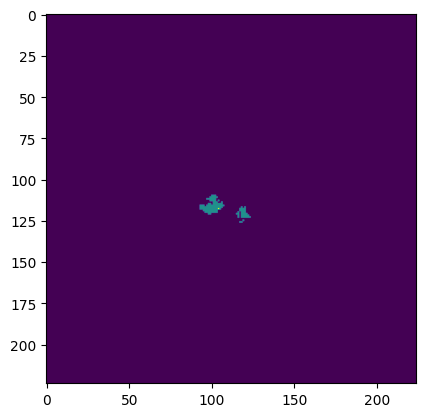

In [58]:
plt.imshow(mask[...,7])

In [53]:
import SimpleITK as sitk
from scipy import ndimage

In [55]:
org_root = "/Users/qixinhu/Project/CUHK/Prostate/PAIsData/0426/tingting/PAIs074/PAIs074_ADC_gt.nii.gz"
adc_gt = sitk.ReadImage(org_root)
adc_gt = sitk.GetArrayFromImage(adc_gt)
adc_gt_old = np.transpose(adc_gt, (1, 2, 0))
adc_gt = np.zeros_like(adc_gt_old)
adc_gt[adc_gt_old>1] = 1

x,y,z = adc_gt.shape
resize_x,resize_y,resize_z = 224, 224, 30

zoom_adc_gt = ndimage.zoom(adc_gt, zoom=(resize_x/x, resize_y/y, resize_z/z), mode="nearest",order=0)
np.max(zoom_adc_gt)

1

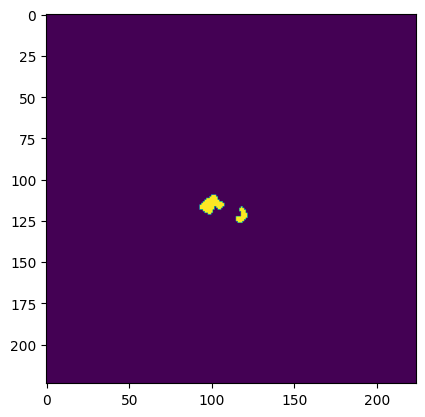

In [57]:
plt.imshow(zoom_adc_gt[...,7])